In [ ]:
#!pip uninstall --yes gdown # After running this line, restart Colab runtime.
#!pip install --upgrade --no-cache-dir gdown
#!pip install torchmetrics

In [ ]:
#import gdown
#url = "https://drive.google.com/drive/folders/1NNVry5TnTsiPIAh3bupQOmGw5NIuDbF0"

#gdown.download_folder(url, quiet=True, use_cookies=True, remaining_ok=True)


**link to preprocessed dataset temporal differences** : https://drive.google.com/drive/folders/19HbCp0bfK0S0ZhEuEs3sVo1PZdhXt3R4?usp=sharing.


**link to preprocessed dataset mel spectogram** : https://drive.google.com/drive/folders/18fYbnTEuDNt34uKihleGOamHdivqsv5D?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
import torch
#import torchmetrics
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset, DataLoader,  SubsetRandomSampler,random_split
from torchvision import transforms
from tqdm import tqdm


In [ ]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on: {device}')

Training on: cpu


In [ ]:
import torchaudio.transforms as transforms

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, min_files=200):
        self.root_dir = root_dir
        self.min_files = min_files
        self.data, self.labels = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx < len(self.data):
            return {'data': self.data[idx], 'label': self.labels[idx]}
        else:
            return {'data': None, 'label': None}

    def load_data(self):
        data = []
        labels = []
        label_encoder = LabelEncoder()
        class_folders = [folder for folder in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, folder))]

        for folder in tqdm(class_folders):
            class_path = os.path.join(self.root_dir, folder)
            files = [f for f in os.listdir(class_path) if f.endswith('.csv')]
            if len(files) >= self.min_files:
                class_label = folder.split('_')[0]
                for file_name in files:
                    file_path = os.path.join(class_path, file_name)
                    try:
                        df = pd.read_csv(file_path)
                        data_tensor = torch.tensor(df[['time_diff', 'mag_diff']].values, dtype=torch.float32).unsqueeze(0)
                        data.append(data_tensor)
                        labels.append(class_label)
                    except Exception as e:
                        print(f"Error processing file {file_path}: {e}")

        if labels:
            labels = label_encoder.fit_transform(labels)
            labels = np.array(labels)

        return data, labels


In [ ]:
# Example usage:
root_folder = "/content/drive/MyDrive/ADV_ML/OGLE3_clean_preprocessed"

In [ ]:
dataset = CustomDataset(root_folder)

100%|██████████| 13/13 [1:15:27<00:00, 348.28s/it]


In [ ]:
len(dataset.data),len(dataset.labels)

(45178, 45178)

In [ ]:
np.unique(dataset.labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
for i, sample in enumerate(dataset):
  print(sample)

  if i == 1:
      break

In [ ]:
# Splitting into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
#num_classes = len(np.unique(dataset.labels))
num_classes = 9


In [ ]:
class ConvNet(nn.Module):
    def __init__(self, input_channels=2, S1=64, S2=32, ncells=128, num_classes=num_classes, window_size=42, stride=2, dropout_rate=0.5):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, S1, kernel_size=window_size, stride=stride)
        self.conv2 = nn.Conv1d(S1, S2, kernel_size=window_size, stride=stride )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3040, ncells)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(ncells, num_classes)

    def forward(self, x):
        #print(x.shape)
        x = x.squeeze(1)
        x = x.permute(0, 2, 1)  # Permute to (batch_size, channels, sequence_length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
model = ConvNet(window_size=42, stride=2, ncells=128, dropout_rate=0.5)
model.to(device)
model

ConvNet(
  (conv1): Conv1d(2, 64, kernel_size=(42,), stride=(2,))
  (conv2): Conv1d(64, 32, kernel_size=(42,), stride=(2,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3040, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [ ]:
# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of weights in the model:", total_params)

Total number of weights in the model: 481897


In [ ]:
# Define your training function
def train_model(model, dataset, num_epochs=10, batch_size=32):
    skf = StratifiedKFold(n_splits=10, shuffle=True)  # Define a 10-fold stratified cross-validation
    for fold, (train_indices, val_indices) in enumerate(skf.split(dataset.data, dataset.labels)):
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in tqdm(range(num_epochs)):
            model.train()
            running_loss = 0.0
            for i, batch in enumerate(train_loader):
                inputs = batch['data'].to(device)
                labels = batch['label'].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Validation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for i, batch in enumerate(val_loader):
                    inputs = batch['data'].to(device)
                    labels = batch['label'].to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_accuracy = correct / total

            print(f"Fold {fold + 1}, Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Val Accuracy: {val_accuracy}")

In [ ]:
train_model(model, dataset)

 10%|█         | 1/10 [00:05<00:48,  5.44s/it]

Fold 1, Epoch 1/10, Loss: 1.2978940324742057, Val Accuracy: 0.5982735723771581


 20%|██        | 2/10 [00:09<00:39,  4.88s/it]

Fold 1, Epoch 2/10, Loss: 1.0386831790419848, Val Accuracy: 0.6485170429393537


 30%|███       | 3/10 [00:14<00:33,  4.86s/it]

Fold 1, Epoch 3/10, Loss: 0.924891969287236, Val Accuracy: 0.6914563966356795


 40%|████      | 4/10 [00:18<00:27,  4.59s/it]

Fold 1, Epoch 4/10, Loss: 0.7633526653262408, Val Accuracy: 0.7416998671978752


 50%|█████     | 5/10 [00:23<00:22,  4.52s/it]

Fold 1, Epoch 5/10, Loss: 0.6428405785659089, Val Accuracy: 0.7892872952633909


 60%|██████    | 6/10 [00:28<00:18,  4.58s/it]

Fold 1, Epoch 6/10, Loss: 0.5703128283179528, Val Accuracy: 0.7945993802567508


 70%|███████   | 7/10 [00:32<00:13,  4.45s/it]

Fold 1, Epoch 7/10, Loss: 0.5231438459583758, Val Accuracy: 0.798804780876494


 80%|████████  | 8/10 [00:36<00:08,  4.36s/it]

Fold 1, Epoch 8/10, Loss: 0.48486623621709135, Val Accuracy: 0.8158477202301904


 90%|█████████ | 9/10 [00:41<00:04,  4.55s/it]

Fold 1, Epoch 9/10, Loss: 0.4597731375441037, Val Accuracy: 0.8222664895971669


100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Fold 1, Epoch 10/10, Loss: 0.42824137102399257, Val Accuracy: 0.8304559539619301


 10%|█         | 1/10 [00:04<00:37,  4.16s/it]

Fold 2, Epoch 1/10, Loss: 0.4530473354819907, Val Accuracy: 0.880256750774679


 20%|██        | 2/10 [00:08<00:35,  4.46s/it]

Fold 2, Epoch 2/10, Loss: 0.4210223119726432, Val Accuracy: 0.8866755201416556


 30%|███       | 3/10 [00:13<00:30,  4.42s/it]

Fold 2, Epoch 3/10, Loss: 0.39810985307422425, Val Accuracy: 0.8691899070385126


 40%|████      | 4/10 [00:17<00:25,  4.30s/it]

Fold 2, Epoch 4/10, Loss: 0.3767248778702892, Val Accuracy: 0.8833554670208057


 50%|█████     | 5/10 [00:21<00:22,  4.43s/it]

Fold 2, Epoch 5/10, Loss: 0.35762095852900827, Val Accuracy: 0.8787073926516158


 60%|██████    | 6/10 [00:26<00:17,  4.35s/it]

Fold 2, Epoch 6/10, Loss: 0.3479203586265105, Val Accuracy: 0.871403275785746


 70%|███████   | 7/10 [00:30<00:13,  4.39s/it]

Fold 2, Epoch 7/10, Loss: 0.3416059985493085, Val Accuracy: 0.8764940239043825


 80%|████████  | 8/10 [00:35<00:08,  4.47s/it]

Fold 2, Epoch 8/10, Loss: 0.32576422480445716, Val Accuracy: 0.8669765382912793


 90%|█████████ | 9/10 [00:39<00:04,  4.38s/it]

Fold 2, Epoch 9/10, Loss: 0.31565538690631356, Val Accuracy: 0.871403275785746


100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


Fold 2, Epoch 10/10, Loss: 0.315348437728608, Val Accuracy: 0.8718459495351926


 10%|█         | 1/10 [00:04<00:41,  4.61s/it]

Fold 3, Epoch 1/10, Loss: 0.3705077076039147, Val Accuracy: 0.9287295263390881


 20%|██        | 2/10 [00:08<00:34,  4.35s/it]

Fold 3, Epoch 2/10, Loss: 0.3201358747777744, Val Accuracy: 0.9318282425852147


 30%|███       | 3/10 [00:12<00:29,  4.25s/it]

Fold 3, Epoch 3/10, Loss: 0.3054234852118932, Val Accuracy: 0.9234174413457282


 40%|████      | 4/10 [00:17<00:27,  4.51s/it]

Fold 3, Epoch 4/10, Loss: 0.2997829025856019, Val Accuracy: 0.9108012394864985


 50%|█████     | 5/10 [00:21<00:21,  4.38s/it]

Fold 3, Epoch 5/10, Loss: 0.2969962820193835, Val Accuracy: 0.9194333776007083


 60%|██████    | 6/10 [00:26<00:17,  4.30s/it]

Fold 3, Epoch 6/10, Loss: 0.27962243314290214, Val Accuracy: 0.9037184594953519


 70%|███████   | 7/10 [00:30<00:13,  4.38s/it]

Fold 3, Epoch 7/10, Loss: 0.284062664067764, Val Accuracy: 0.9101372288623285


 80%|████████  | 8/10 [00:35<00:08,  4.39s/it]

Fold 3, Epoch 8/10, Loss: 0.2791489149853411, Val Accuracy: 0.9077025232403718


 90%|█████████ | 9/10 [00:39<00:04,  4.32s/it]

Fold 3, Epoch 9/10, Loss: 0.30432861390648913, Val Accuracy: 0.9052678176184152


100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


Fold 3, Epoch 10/10, Loss: 0.2691089832769849, Val Accuracy: 0.9081451969898185


 10%|█         | 1/10 [00:04<00:38,  4.23s/it]

Fold 4, Epoch 1/10, Loss: 0.31646533346318007, Val Accuracy: 0.9311642319610447


 20%|██        | 2/10 [00:08<00:34,  4.32s/it]

Fold 4, Epoch 2/10, Loss: 0.2791505453582006, Val Accuracy: 0.9406817175741479


 30%|███       | 3/10 [00:13<00:31,  4.48s/it]

Fold 4, Epoch 3/10, Loss: 0.2712241274976618, Val Accuracy: 0.9355909694555112


 40%|████      | 4/10 [00:17<00:26,  4.38s/it]

Fold 4, Epoch 4/10, Loss: 0.26462874919129203, Val Accuracy: 0.9200973882248783


 50%|█████     | 5/10 [00:21<00:21,  4.38s/it]

Fold 4, Epoch 5/10, Loss: 0.26660757382450895, Val Accuracy: 0.9262948207171314


 60%|██████    | 6/10 [00:26<00:17,  4.46s/it]

Fold 4, Epoch 6/10, Loss: 0.26614415227346866, Val Accuracy: 0.9300575475874281


 70%|███████   | 7/10 [00:30<00:13,  4.36s/it]

Fold 4, Epoch 7/10, Loss: 0.24560447364025562, Val Accuracy: 0.9269588313413014


 80%|████████  | 8/10 [00:34<00:08,  4.31s/it]

Fold 4, Epoch 8/10, Loss: 0.25402306225868915, Val Accuracy: 0.9176626826029216


 90%|█████████ | 9/10 [00:39<00:04,  4.46s/it]

Fold 4, Epoch 9/10, Loss: 0.2554459474734628, Val Accuracy: 0.9207613988490483


100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


Fold 4, Epoch 10/10, Loss: 0.2403372949535902, Val Accuracy: 0.9163346613545816


 10%|█         | 1/10 [00:04<00:37,  4.14s/it]

Fold 5, Epoch 1/10, Loss: 0.28108216208544284, Val Accuracy: 0.9546259406817176


 20%|██        | 2/10 [00:08<00:35,  4.42s/it]

Fold 5, Epoch 2/10, Loss: 0.2527807091013254, Val Accuracy: 0.9519698981850376


 30%|███       | 3/10 [00:13<00:31,  4.43s/it]

Fold 5, Epoch 3/10, Loss: 0.2541836303644861, Val Accuracy: 0.9466578131916777


 40%|████      | 4/10 [00:17<00:25,  4.31s/it]

Fold 5, Epoch 4/10, Loss: 0.24303616486771148, Val Accuracy: 0.9486498450641877


 50%|█████     | 5/10 [00:21<00:22,  4.42s/it]

Fold 5, Epoch 5/10, Loss: 0.25890444408857466, Val Accuracy: 0.9389110225763613


 60%|██████    | 6/10 [00:26<00:17,  4.34s/it]

Fold 5, Epoch 6/10, Loss: 0.24915604509360484, Val Accuracy: 0.9413457281983179


 70%|███████   | 7/10 [00:30<00:13,  4.36s/it]

Fold 5, Epoch 7/10, Loss: 0.22990728642155484, Val Accuracy: 0.9409030544488712


 80%|████████  | 8/10 [00:35<00:08,  4.45s/it]

Fold 5, Epoch 8/10, Loss: 0.24333118644039595, Val Accuracy: 0.9373616644532979


 90%|█████████ | 9/10 [00:39<00:04,  4.36s/it]

Fold 5, Epoch 9/10, Loss: 0.23531963192234234, Val Accuracy: 0.9358123063302346


100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


Fold 5, Epoch 10/10, Loss: 0.22560728777179467, Val Accuracy: 0.9243027888446215


 10%|█         | 1/10 [00:04<00:43,  4.88s/it]

Fold 6, Epoch 1/10, Loss: 0.27223597420049783, Val Accuracy: 0.9557326250553342


 20%|██        | 2/10 [00:09<00:35,  4.47s/it]

Fold 6, Epoch 2/10, Loss: 0.2401686016987514, Val Accuracy: 0.9486498450641877


 30%|███       | 3/10 [00:13<00:30,  4.34s/it]

Fold 6, Epoch 3/10, Loss: 0.23834421430779643, Val Accuracy: 0.9572819831783975


 40%|████      | 4/10 [00:17<00:26,  4.45s/it]

Fold 6, Epoch 4/10, Loss: 0.23392338238921775, Val Accuracy: 0.9530765825586542


 50%|█████     | 5/10 [00:22<00:22,  4.43s/it]

Fold 6, Epoch 5/10, Loss: 0.24449246827026436, Val Accuracy: 0.9506418769366977


 60%|██████    | 6/10 [00:26<00:17,  4.35s/it]

Fold 6, Epoch 6/10, Loss: 0.25391056140746265, Val Accuracy: 0.9402390438247012


 70%|███████   | 7/10 [00:31<00:13,  4.44s/it]

Fold 6, Epoch 7/10, Loss: 0.22554559604265528, Val Accuracy: 0.9482071713147411


 80%|████████  | 8/10 [00:35<00:08,  4.36s/it]

Fold 6, Epoch 8/10, Loss: 0.23995975106053294, Val Accuracy: 0.9437804338202744


 90%|█████████ | 9/10 [00:39<00:04,  4.38s/it]

Fold 6, Epoch 9/10, Loss: 0.21413953204175426, Val Accuracy: 0.9417884019477645


100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


Fold 6, Epoch 10/10, Loss: 0.21704785718227554, Val Accuracy: 0.9420097388224878


 10%|█         | 1/10 [00:04<00:37,  4.14s/it]

Fold 7, Epoch 1/10, Loss: 0.27098240836924287, Val Accuracy: 0.9566179725542275


 20%|██        | 2/10 [00:08<00:33,  4.17s/it]

Fold 7, Epoch 2/10, Loss: 0.28276975993887704, Val Accuracy: 0.9592740150509075


 30%|███       | 3/10 [00:13<00:31,  4.48s/it]

Fold 7, Epoch 3/10, Loss: 0.2364309421285436, Val Accuracy: 0.9628154050464808


 40%|████      | 4/10 [00:17<00:26,  4.34s/it]

Fold 7, Epoch 4/10, Loss: 0.251364971505204, Val Accuracy: 0.9550686144311642


 50%|█████     | 5/10 [00:21<00:21,  4.28s/it]

Fold 7, Epoch 5/10, Loss: 0.22065322367689866, Val Accuracy: 0.9586100044267375


 60%|██████    | 6/10 [00:26<00:17,  4.41s/it]

Fold 7, Epoch 6/10, Loss: 0.2321343407339697, Val Accuracy: 0.950199203187251


 70%|███████   | 7/10 [00:30<00:13,  4.42s/it]

Fold 7, Epoch 7/10, Loss: 0.21902924371014235, Val Accuracy: 0.9426737494466578


 80%|████████  | 8/10 [00:34<00:08,  4.33s/it]

Fold 7, Epoch 8/10, Loss: 0.22961175256100264, Val Accuracy: 0.9459938025675078


 90%|█████████ | 9/10 [00:39<00:04,  4.43s/it]

Fold 7, Epoch 9/10, Loss: 0.21397410918329055, Val Accuracy: 0.9471004869411244


100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


Fold 7, Epoch 10/10, Loss: 0.2584983325782463, Val Accuracy: 0.9473218238158477


 10%|█         | 1/10 [00:04<00:39,  4.38s/it]

Fold 8, Epoch 1/10, Loss: 0.2597915340906682, Val Accuracy: 0.9681274900398407


 20%|██        | 2/10 [00:08<00:36,  4.52s/it]

Fold 8, Epoch 2/10, Loss: 0.23086246099421223, Val Accuracy: 0.9603806994245241


 30%|███       | 3/10 [00:13<00:30,  4.38s/it]

Fold 8, Epoch 3/10, Loss: 0.237381601396378, Val Accuracy: 0.9608233731739708


 40%|████      | 4/10 [00:17<00:26,  4.38s/it]

Fold 8, Epoch 4/10, Loss: 0.21892861759507726, Val Accuracy: 0.9561752988047809


 50%|█████     | 5/10 [00:22<00:22,  4.47s/it]

Fold 8, Epoch 5/10, Loss: 0.23995498368805268, Val Accuracy: 0.9550686144311642


 60%|██████    | 6/10 [00:26<00:17,  4.38s/it]

Fold 8, Epoch 6/10, Loss: 0.2356293596307887, Val Accuracy: 0.9550686144311642


 70%|███████   | 7/10 [00:30<00:12,  4.32s/it]

Fold 8, Epoch 7/10, Loss: 0.21813703885790692, Val Accuracy: 0.9568393094289509


 80%|████████  | 8/10 [00:35<00:09,  4.50s/it]

Fold 8, Epoch 8/10, Loss: 0.21172626638425227, Val Accuracy: 0.9561752988047809


 90%|█████████ | 9/10 [00:39<00:04,  4.40s/it]

Fold 8, Epoch 9/10, Loss: 0.2305188737699746, Val Accuracy: 0.950863213811421


100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


Fold 8, Epoch 10/10, Loss: 0.22287002551119503, Val Accuracy: 0.9462151394422311


 10%|█         | 1/10 [00:04<00:42,  4.68s/it]

Fold 9, Epoch 1/10, Loss: 0.2807881962258829, Val Accuracy: 0.9524020367500553


 20%|██        | 2/10 [00:09<00:36,  4.53s/it]

Fold 9, Epoch 2/10, Loss: 0.2481305682485781, Val Accuracy: 0.9687845915430595


 30%|███       | 3/10 [00:13<00:30,  4.38s/it]

Fold 9, Epoch 3/10, Loss: 0.22992346011304438, Val Accuracy: 0.9628071729023688


 40%|████      | 4/10 [00:17<00:26,  4.48s/it]

Fold 9, Epoch 4/10, Loss: 0.24544662552248953, Val Accuracy: 0.9574939118884215


 50%|█████     | 5/10 [00:22<00:21,  4.37s/it]

Fold 9, Epoch 5/10, Loss: 0.26273016578002734, Val Accuracy: 0.9455390746070401


 60%|██████    | 6/10 [00:26<00:17,  4.38s/it]

Fold 9, Epoch 6/10, Loss: 0.21500556910429575, Val Accuracy: 0.9643568740314368


 70%|███████   | 7/10 [00:31<00:13,  4.48s/it]

Fold 9, Epoch 7/10, Loss: 0.21856602522103816, Val Accuracy: 0.9561655966349347


 80%|████████  | 8/10 [00:35<00:08,  4.39s/it]

Fold 9, Epoch 8/10, Loss: 0.2287768968390605, Val Accuracy: 0.9495240203675005


 90%|█████████ | 9/10 [00:39<00:04,  4.38s/it]

Fold 9, Epoch 9/10, Loss: 0.22615852745038836, Val Accuracy: 0.9475315474872703


100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


Fold 9, Epoch 10/10, Loss: 0.22823489869063254, Val Accuracy: 0.951959264998893


 10%|█         | 1/10 [00:04<00:37,  4.15s/it]

Fold 10, Epoch 1/10, Loss: 0.2678158380101082, Val Accuracy: 0.9532875802523799


 20%|██        | 2/10 [00:08<00:33,  4.15s/it]

Fold 10, Epoch 2/10, Loss: 0.2326844705905865, Val Accuracy: 0.9718839938011955


 30%|███       | 3/10 [00:13<00:31,  4.45s/it]

Fold 10, Epoch 3/10, Loss: 0.2333078341594114, Val Accuracy: 0.9667921186628293


 40%|████      | 4/10 [00:17<00:26,  4.35s/it]

Fold 10, Epoch 4/10, Loss: 0.2208286765120179, Val Accuracy: 0.9674562762895728


 50%|█████     | 5/10 [00:21<00:21,  4.28s/it]

Fold 10, Epoch 5/10, Loss: 0.2196467062471219, Val Accuracy: 0.9634713305291123


 60%|██████    | 6/10 [00:26<00:17,  4.40s/it]

Fold 10, Epoch 6/10, Loss: 0.2209134850014268, Val Accuracy: 0.9634713305291123


 70%|███████   | 7/10 [00:30<00:13,  4.40s/it]

Fold 10, Epoch 7/10, Loss: 0.22346616187004664, Val Accuracy: 0.9652424175337614


 80%|████████  | 8/10 [00:34<00:08,  4.32s/it]

Fold 10, Epoch 8/10, Loss: 0.21869433386824522, Val Accuracy: 0.9539517378791234


 90%|█████████ | 9/10 [00:39<00:04,  4.41s/it]

Fold 10, Epoch 9/10, Loss: 0.25025785096901243, Val Accuracy: 0.9572725260128404


100%|██████████| 10/10 [00:43<00:00,  4.34s/it]

Fold 10, Epoch 10/10, Loss: 0.20964559483208878, Val Accuracy: 0.9586008412663272


In [ ]:
model2 = ConvNet(window_size=42, stride=2, ncells=128, dropout_rate=0.5)
model2.to(device)
model2

ConvNet(
  (conv1): Conv1d(2, 64, kernel_size=(42,), stride=(2,))
  (conv2): Conv1d(64, 32, kernel_size=(42,), stride=(2,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3040, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [ ]:
len(dataset.labels)

45178

In [ ]:
def train_model(model_class, dataset, num_epochs=16, batch_size=32, device='cuda'):
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=9, average='weighted').to(device)
    f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=9, average='weighted').to(device)

    fold_accuracies = []
    fold_f1_scores = []

    for fold, (train_indices, val_indices) in enumerate(skf.split(dataset.data, dataset.labels)):
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        epoch_accuracies = []
        epoch_f1_scores = []

        model = model_class().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


        for epoch in tqdm(range(num_epochs), desc=f'Fold {fold+1}'):
            model.train()
            running_loss = 0.0
            for i, batch in enumerate(train_loader):
                inputs, labels = batch['data'].to(device), batch['label'].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                #print(outputs.shape[1])
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()


            model.eval()
            accuracy_metric.reset()
            f1_metric.reset()
            with torch.no_grad():
                for i, batch in enumerate(val_loader):
                    inputs, labels = batch['data'].to(device), batch['label'].to(device)
                    outputs = model(inputs)
                    accuracy_metric.update(outputs, labels)
                    f1_metric.update(outputs, labels)

            epoch_accuracies.append(accuracy_metric.compute().item())
            epoch_f1_scores.append(f1_metric.compute().item())

            print(f'Fold {fold+1}, Epoch {epoch+1}: Validation Weighted Accuracy: {epoch_accuracies[-1]}, Validation Weighted F1 Score: {epoch_f1_scores[-1]}')

        fold_accuracies.append(epoch_accuracies)
        fold_f1_scores.append(epoch_f1_scores)

    # Plotting the results
    plt.figure(figsize=(8, 7))
    for i in range(10):
        plt.subplot(2, 1, 1)
        plt.plot(range(1, num_epochs + 1), fold_accuracies[i], label=f'Fold {i+1}')
        plt.title('Validation Weighted Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Weighted Accuracy')
        plt.legend(loc='upper left')
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.plot(range(1, num_epochs + 1), fold_f1_scores[i], label=f'Fold {i+1}')
        plt.title('Validation Weighted F1 Score per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Weighted F1 Score')
        plt.legend(loc='upper left')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    return fold_accuracies, fold_f1_scores


Fold 1:   6%|▋         | 1/16 [00:06<01:33,  6.26s/it]

Fold 1, Epoch 1: Validation Weighted Accuracy: 0.6100044250488281, Validation Weighted F1 Score: 0.5879284143447876


Fold 1:  12%|█▎        | 2/16 [00:10<01:11,  5.13s/it]

Fold 1, Epoch 2: Validation Weighted Accuracy: 0.6341301202774048, Validation Weighted F1 Score: 0.6152874231338501


Fold 1:  19%|█▉        | 3/16 [00:15<01:05,  5.00s/it]

Fold 1, Epoch 3: Validation Weighted Accuracy: 0.704736590385437, Validation Weighted F1 Score: 0.6856858730316162


Fold 1:  25%|██▌       | 4/16 [00:20<00:57,  4.83s/it]

Fold 1, Epoch 4: Validation Weighted Accuracy: 0.7647188901901245, Validation Weighted F1 Score: 0.7520784139633179


Fold 1:  31%|███▏      | 5/16 [00:24<00:51,  4.65s/it]

Fold 1, Epoch 5: Validation Weighted Accuracy: 0.7609562277793884, Validation Weighted F1 Score: 0.7505117058753967


Fold 1:  38%|███▊      | 6/16 [00:29<00:47,  4.72s/it]

Fold 1, Epoch 6: Validation Weighted Accuracy: 0.7833111882209778, Validation Weighted F1 Score: 0.7736217975616455


Fold 1:  44%|████▍     | 7/16 [00:33<00:41,  4.60s/it]

Fold 1, Epoch 7: Validation Weighted Accuracy: 0.7857459187507629, Validation Weighted F1 Score: 0.7763895988464355


Fold 1:  50%|█████     | 8/16 [00:38<00:36,  4.58s/it]

Fold 1, Epoch 8: Validation Weighted Accuracy: 0.8067728877067566, Validation Weighted F1 Score: 0.8000220656394958


Fold 1:  56%|█████▋    | 9/16 [00:42<00:32,  4.66s/it]

Fold 1, Epoch 9: Validation Weighted Accuracy: 0.8065515756607056, Validation Weighted F1 Score: 0.7972232699394226


Fold 1:  62%|██████▎   | 10/16 [00:47<00:27,  4.57s/it]

Fold 1, Epoch 10: Validation Weighted Accuracy: 0.818061113357544, Validation Weighted F1 Score: 0.8116286993026733


Fold 1:  69%|██████▉   | 11/16 [00:51<00:22,  4.60s/it]

Fold 1, Epoch 11: Validation Weighted Accuracy: 0.8233731389045715, Validation Weighted F1 Score: 0.8171586990356445


Fold 1:  75%|███████▌  | 12/16 [00:56<00:18,  4.66s/it]

Fold 1, Epoch 12: Validation Weighted Accuracy: 0.818061113357544, Validation Weighted F1 Score: 0.8125738501548767


Fold 1:  81%|████████▏ | 13/16 [01:01<00:13,  4.55s/it]

Fold 1, Epoch 13: Validation Weighted Accuracy: 0.8249225616455078, Validation Weighted F1 Score: 0.8203849792480469


Fold 1:  88%|████████▊ | 14/16 [01:05<00:09,  4.51s/it]

Fold 1, Epoch 14: Validation Weighted Accuracy: 0.8262506127357483, Validation Weighted F1 Score: 0.8230766654014587


Fold 1:  94%|█████████▍| 15/16 [01:10<00:04,  4.67s/it]

Fold 1, Epoch 15: Validation Weighted Accuracy: 0.8224878311157227, Validation Weighted F1 Score: 0.817421555519104


Fold 1: 100%|██████████| 16/16 [01:14<00:00,  4.68s/it]


Fold 1, Epoch 16: Validation Weighted Accuracy: 0.8300132751464844, Validation Weighted F1 Score: 0.8280717730522156


Fold 2:   6%|▋         | 1/16 [00:04<01:07,  4.50s/it]

Fold 2, Epoch 1: Validation Weighted Accuracy: 0.6184152364730835, Validation Weighted F1 Score: 0.598831295967102


Fold 2:  12%|█▎        | 2/16 [00:09<01:05,  4.65s/it]

Fold 2, Epoch 2: Validation Weighted Accuracy: 0.6474103927612305, Validation Weighted F1 Score: 0.6277345418930054


Fold 2:  19%|█▉        | 3/16 [00:13<01:00,  4.65s/it]

Fold 2, Epoch 3: Validation Weighted Accuracy: 0.6726427674293518, Validation Weighted F1 Score: 0.6560449600219727


Fold 2:  25%|██▌       | 4/16 [00:18<00:55,  4.63s/it]

Fold 2, Epoch 4: Validation Weighted Accuracy: 0.7133687138557434, Validation Weighted F1 Score: 0.6968074440956116


Fold 2:  31%|███▏      | 5/16 [00:23<00:51,  4.67s/it]

Fold 2, Epoch 5: Validation Weighted Accuracy: 0.7695883512496948, Validation Weighted F1 Score: 0.7600065469741821


Fold 2:  38%|███▊      | 6/16 [00:27<00:46,  4.64s/it]

Fold 2, Epoch 6: Validation Weighted Accuracy: 0.795263409614563, Validation Weighted F1 Score: 0.7887765169143677


Fold 2:  44%|████▍     | 7/16 [00:32<00:41,  4.62s/it]

Fold 2, Epoch 7: Validation Weighted Accuracy: 0.8007968068122864, Validation Weighted F1 Score: 0.7939328551292419


Fold 2:  50%|█████     | 8/16 [00:37<00:36,  4.62s/it]

Fold 2, Epoch 8: Validation Weighted Accuracy: 0.8098716735839844, Validation Weighted F1 Score: 0.8032481670379639


Fold 2:  56%|█████▋    | 9/16 [00:41<00:31,  4.53s/it]

Fold 2, Epoch 9: Validation Weighted Accuracy: 0.8171757459640503, Validation Weighted F1 Score: 0.8126213550567627


Fold 2:  62%|██████▎   | 10/16 [00:46<00:27,  4.64s/it]

Fold 2, Epoch 10: Validation Weighted Accuracy: 0.821602463722229, Validation Weighted F1 Score: 0.8164790272712708


Fold 2:  69%|██████▉   | 11/16 [00:50<00:23,  4.64s/it]

Fold 2, Epoch 11: Validation Weighted Accuracy: 0.8222665190696716, Validation Weighted F1 Score: 0.8183786869049072


Fold 2:  75%|███████▌  | 12/16 [00:55<00:18,  4.55s/it]

Fold 2, Epoch 12: Validation Weighted Accuracy: 0.8202744722366333, Validation Weighted F1 Score: 0.8168016076087952


Fold 2:  81%|████████▏ | 13/16 [00:59<00:13,  4.58s/it]

Fold 2, Epoch 13: Validation Weighted Accuracy: 0.827799916267395, Validation Weighted F1 Score: 0.8248205184936523


Fold 2:  88%|████████▊ | 14/16 [01:04<00:09,  4.66s/it]

Fold 2, Epoch 14: Validation Weighted Accuracy: 0.8202744722366333, Validation Weighted F1 Score: 0.8168469667434692


Fold 2:  94%|█████████▍| 15/16 [01:09<00:04,  4.57s/it]

Fold 2, Epoch 15: Validation Weighted Accuracy: 0.8322266340255737, Validation Weighted F1 Score: 0.8308695554733276


Fold 2: 100%|██████████| 16/16 [01:13<00:00,  4.61s/it]


Fold 2, Epoch 16: Validation Weighted Accuracy: 0.8304559588432312, Validation Weighted F1 Score: 0.8272333145141602


Fold 3:   6%|▋         | 1/16 [00:04<01:08,  4.58s/it]

Fold 3, Epoch 1: Validation Weighted Accuracy: 0.6035856604576111, Validation Weighted F1 Score: 0.5844138860702515


Fold 3:  12%|█▎        | 2/16 [00:09<01:04,  4.61s/it]

Fold 3, Epoch 2: Validation Weighted Accuracy: 0.6385568976402283, Validation Weighted F1 Score: 0.6216281056404114


Fold 3:  19%|█▉        | 3/16 [00:13<01:00,  4.67s/it]

Fold 3, Epoch 3: Validation Weighted Accuracy: 0.707614004611969, Validation Weighted F1 Score: 0.6934311985969543


Fold 3:  25%|██▌       | 4/16 [00:18<00:55,  4.60s/it]

Fold 3, Epoch 4: Validation Weighted Accuracy: 0.7740150690078735, Validation Weighted F1 Score: 0.7609407305717468


Fold 3:  31%|███▏      | 5/16 [00:22<00:49,  4.52s/it]

Fold 3, Epoch 5: Validation Weighted Accuracy: 0.7868525981903076, Validation Weighted F1 Score: 0.7756102681159973


Fold 3:  38%|███▊      | 6/16 [00:27<00:47,  4.70s/it]

Fold 3, Epoch 6: Validation Weighted Accuracy: 0.8038954734802246, Validation Weighted F1 Score: 0.7972987294197083


Fold 3:  44%|████▍     | 7/16 [00:32<00:41,  4.61s/it]

Fold 3, Epoch 7: Validation Weighted Accuracy: 0.8078795671463013, Validation Weighted F1 Score: 0.8022909760475159


Fold 3:  50%|█████     | 8/16 [00:36<00:36,  4.52s/it]

Fold 3, Epoch 8: Validation Weighted Accuracy: 0.8167331218719482, Validation Weighted F1 Score: 0.8113901615142822


Fold 3:  56%|█████▋    | 9/16 [00:41<00:32,  4.62s/it]

Fold 3, Epoch 9: Validation Weighted Accuracy: 0.8187251091003418, Validation Weighted F1 Score: 0.8120293021202087


Fold 3:  62%|██████▎   | 10/16 [00:46<00:27,  4.62s/it]

Fold 3, Epoch 10: Validation Weighted Accuracy: 0.8258078694343567, Validation Weighted F1 Score: 0.8207418918609619


Fold 3:  69%|██████▉   | 11/16 [00:50<00:22,  4.52s/it]

Fold 3, Epoch 11: Validation Weighted Accuracy: 0.8220452070236206, Validation Weighted F1 Score: 0.819049596786499


Fold 3:  75%|███████▌  | 12/16 [00:55<00:18,  4.63s/it]

Fold 3, Epoch 12: Validation Weighted Accuracy: 0.8247012495994568, Validation Weighted F1 Score: 0.8202693462371826


Fold 3:  81%|████████▏ | 13/16 [00:59<00:13,  4.61s/it]

Fold 3, Epoch 13: Validation Weighted Accuracy: 0.8244798183441162, Validation Weighted F1 Score: 0.8214394450187683


Fold 3:  88%|████████▊ | 14/16 [01:04<00:09,  4.55s/it]

Fold 3, Epoch 14: Validation Weighted Accuracy: 0.8373174071311951, Validation Weighted F1 Score: 0.8348619341850281


Fold 3:  94%|█████████▍| 15/16 [01:09<00:04,  4.64s/it]

Fold 3, Epoch 15: Validation Weighted Accuracy: 0.8417441844940186, Validation Weighted F1 Score: 0.8388727903366089


Fold 3: 100%|██████████| 16/16 [01:13<00:00,  4.59s/it]


Fold 3, Epoch 16: Validation Weighted Accuracy: 0.8461709022521973, Validation Weighted F1 Score: 0.8417882323265076


Fold 4:   6%|▋         | 1/16 [00:04<01:08,  4.54s/it]

Fold 4, Epoch 1: Validation Weighted Accuracy: 0.600044310092926, Validation Weighted F1 Score: 0.5815678834915161


Fold 4:  12%|█▎        | 2/16 [00:09<01:06,  4.72s/it]

Fold 4, Epoch 2: Validation Weighted Accuracy: 0.6352367997169495, Validation Weighted F1 Score: 0.6181846857070923


Fold 4:  19%|█▉        | 3/16 [00:13<00:59,  4.54s/it]

Fold 4, Epoch 3: Validation Weighted Accuracy: 0.6660026907920837, Validation Weighted F1 Score: 0.6509168148040771


Fold 4:  25%|██▌       | 4/16 [00:18<00:53,  4.48s/it]

Fold 4, Epoch 4: Validation Weighted Accuracy: 0.7485613226890564, Validation Weighted F1 Score: 0.7346928119659424


Fold 4:  31%|███▏      | 5/16 [00:23<00:51,  4.70s/it]

Fold 4, Epoch 5: Validation Weighted Accuracy: 0.7394864559173584, Validation Weighted F1 Score: 0.7287153005599976


Fold 4:  38%|███▊      | 6/16 [00:27<00:45,  4.57s/it]

Fold 4, Epoch 6: Validation Weighted Accuracy: 0.7912793159484863, Validation Weighted F1 Score: 0.7860143184661865


Fold 4:  44%|████▍     | 7/16 [00:31<00:40,  4.49s/it]

Fold 4, Epoch 7: Validation Weighted Accuracy: 0.7957060933113098, Validation Weighted F1 Score: 0.7916556596755981


Fold 4:  50%|█████     | 8/16 [00:36<00:36,  4.61s/it]

Fold 4, Epoch 8: Validation Weighted Accuracy: 0.8030101656913757, Validation Weighted F1 Score: 0.7957782745361328


Fold 4:  56%|█████▋    | 9/16 [00:41<00:32,  4.59s/it]

Fold 4, Epoch 9: Validation Weighted Accuracy: 0.8120850324630737, Validation Weighted F1 Score: 0.8061639666557312


Fold 4:  62%|██████▎   | 10/16 [00:45<00:27,  4.51s/it]

Fold 4, Epoch 10: Validation Weighted Accuracy: 0.8191677927970886, Validation Weighted F1 Score: 0.8167136311531067


Fold 4:  69%|██████▉   | 11/16 [00:50<00:23,  4.62s/it]

Fold 4, Epoch 11: Validation Weighted Accuracy: 0.8032315373420715, Validation Weighted F1 Score: 0.798973560333252


Fold 4:  75%|███████▌  | 12/16 [00:54<00:18,  4.59s/it]

Fold 4, Epoch 12: Validation Weighted Accuracy: 0.8189464807510376, Validation Weighted F1 Score: 0.8135858178138733


Fold 4:  81%|████████▏ | 13/16 [00:59<00:13,  4.53s/it]

Fold 4, Epoch 13: Validation Weighted Accuracy: 0.8167331218719482, Validation Weighted F1 Score: 0.8140016794204712


Fold 4:  88%|████████▊ | 14/16 [01:04<00:09,  4.60s/it]

Fold 4, Epoch 14: Validation Weighted Accuracy: 0.8351041078567505, Validation Weighted F1 Score: 0.8322610259056091


Fold 4:  94%|█████████▍| 15/16 [01:08<00:04,  4.51s/it]

Fold 4, Epoch 15: Validation Weighted Accuracy: 0.8370960354804993, Validation Weighted F1 Score: 0.8348947763442993


Fold 4: 100%|██████████| 16/16 [01:13<00:00,  4.57s/it]


Fold 4, Epoch 16: Validation Weighted Accuracy: 0.8408587574958801, Validation Weighted F1 Score: 0.8386405110359192


Fold 5:   6%|▋         | 1/16 [00:04<01:11,  4.77s/it]

Fold 5, Epoch 1: Validation Weighted Accuracy: 0.6013723015785217, Validation Weighted F1 Score: 0.5806357860565186


Fold 5:  12%|█▎        | 2/16 [00:09<01:03,  4.51s/it]

Fold 5, Epoch 2: Validation Weighted Accuracy: 0.6279326677322388, Validation Weighted F1 Score: 0.6076352596282959


Fold 5:  19%|█▉        | 3/16 [00:13<00:58,  4.48s/it]

Fold 5, Epoch 3: Validation Weighted Accuracy: 0.6513944268226624, Validation Weighted F1 Score: 0.6284762620925903


Fold 5:  25%|██▌       | 4/16 [00:18<00:56,  4.71s/it]

Fold 5, Epoch 4: Validation Weighted Accuracy: 0.6808322072029114, Validation Weighted F1 Score: 0.6617047786712646


Fold 5:  31%|███▏      | 5/16 [00:22<00:50,  4.57s/it]

Fold 5, Epoch 5: Validation Weighted Accuracy: 0.7485612630844116, Validation Weighted F1 Score: 0.7367568016052246


Fold 5:  38%|███▊      | 6/16 [00:27<00:45,  4.55s/it]

Fold 5, Epoch 6: Validation Weighted Accuracy: 0.7733510732650757, Validation Weighted F1 Score: 0.7632443308830261


Fold 5:  44%|████▍     | 7/16 [00:32<00:41,  4.62s/it]

Fold 5, Epoch 7: Validation Weighted Accuracy: 0.789065957069397, Validation Weighted F1 Score: 0.7812322974205017


Fold 5:  50%|█████     | 8/16 [00:36<00:36,  4.59s/it]

Fold 5, Epoch 8: Validation Weighted Accuracy: 0.8089863061904907, Validation Weighted F1 Score: 0.8029244542121887


Fold 5:  56%|█████▋    | 9/16 [00:41<00:31,  4.56s/it]

Fold 5, Epoch 9: Validation Weighted Accuracy: 0.8025674819946289, Validation Weighted F1 Score: 0.7958703637123108


Fold 5:  62%|██████▎   | 10/16 [00:45<00:27,  4.62s/it]

Fold 5, Epoch 10: Validation Weighted Accuracy: 0.8096502423286438, Validation Weighted F1 Score: 0.8021547198295593


Fold 5:  69%|██████▉   | 11/16 [00:50<00:22,  4.53s/it]

Fold 5, Epoch 11: Validation Weighted Accuracy: 0.8027888536453247, Validation Weighted F1 Score: 0.7969049215316772


Fold 5:  75%|███████▌  | 12/16 [00:55<00:18,  4.62s/it]

Fold 5, Epoch 12: Validation Weighted Accuracy: 0.8231518268585205, Validation Weighted F1 Score: 0.81697016954422


Fold 5:  81%|████████▏ | 13/16 [00:59<00:13,  4.64s/it]

Fold 5, Epoch 13: Validation Weighted Accuracy: 0.8196104168891907, Validation Weighted F1 Score: 0.8169664740562439


Fold 5:  88%|████████▊ | 14/16 [01:04<00:09,  4.54s/it]

Fold 5, Epoch 14: Validation Weighted Accuracy: 0.8247011303901672, Validation Weighted F1 Score: 0.8207816481590271


Fold 5:  94%|█████████▍| 15/16 [01:08<00:04,  4.56s/it]

Fold 5, Epoch 15: Validation Weighted Accuracy: 0.8266932368278503, Validation Weighted F1 Score: 0.8225327134132385


Fold 5: 100%|██████████| 16/16 [01:13<00:00,  4.60s/it]


Fold 5, Epoch 16: Validation Weighted Accuracy: 0.8158477544784546, Validation Weighted F1 Score: 0.8115887641906738


Fold 6:   6%|▋         | 1/16 [00:04<01:04,  4.32s/it]

Fold 6, Epoch 1: Validation Weighted Accuracy: 0.6060203909873962, Validation Weighted F1 Score: 0.5803556442260742


Fold 6:  12%|█▎        | 2/16 [00:08<01:02,  4.49s/it]

Fold 6, Epoch 2: Validation Weighted Accuracy: 0.6604692935943604, Validation Weighted F1 Score: 0.6401022672653198


Fold 6:  19%|█▉        | 3/16 [00:13<00:59,  4.55s/it]

Fold 6, Epoch 3: Validation Weighted Accuracy: 0.7058432102203369, Validation Weighted F1 Score: 0.6893895864486694


Fold 6:  25%|██▌       | 4/16 [00:18<00:54,  4.55s/it]

Fold 6, Epoch 4: Validation Weighted Accuracy: 0.756972074508667, Validation Weighted F1 Score: 0.7440009713172913


Fold 6:  31%|███▏      | 5/16 [00:22<00:50,  4.59s/it]

Fold 6, Epoch 5: Validation Weighted Accuracy: 0.7859672904014587, Validation Weighted F1 Score: 0.776229977607727


Fold 6:  38%|███▊      | 6/16 [00:27<00:45,  4.59s/it]

Fold 6, Epoch 6: Validation Weighted Accuracy: 0.8069941997528076, Validation Weighted F1 Score: 0.7989218831062317


Fold 6:  44%|████▍     | 7/16 [00:31<00:40,  4.51s/it]

Fold 6, Epoch 7: Validation Weighted Accuracy: 0.8134130239486694, Validation Weighted F1 Score: 0.8069257140159607


Fold 6:  50%|█████     | 8/16 [00:36<00:37,  4.65s/it]

Fold 6, Epoch 8: Validation Weighted Accuracy: 0.8056662082672119, Validation Weighted F1 Score: 0.7982483506202698


Fold 6:  56%|█████▋    | 9/16 [00:41<00:32,  4.60s/it]

Fold 6, Epoch 9: Validation Weighted Accuracy: 0.8224878311157227, Validation Weighted F1 Score: 0.817221999168396


Fold 6:  62%|██████▎   | 10/16 [00:45<00:27,  4.51s/it]

Fold 6, Epoch 10: Validation Weighted Accuracy: 0.8311198949813843, Validation Weighted F1 Score: 0.8265852332115173


Fold 6:  69%|██████▉   | 11/16 [00:50<00:22,  4.57s/it]

Fold 6, Epoch 11: Validation Weighted Accuracy: 0.8406373858451843, Validation Weighted F1 Score: 0.8363910913467407


Fold 6:  75%|███████▌  | 12/16 [00:54<00:18,  4.64s/it]

Fold 6, Epoch 12: Validation Weighted Accuracy: 0.8406374454498291, Validation Weighted F1 Score: 0.8365820646286011


Fold 6:  81%|████████▏ | 13/16 [00:59<00:13,  4.54s/it]

Fold 6, Epoch 13: Validation Weighted Accuracy: 0.8439575433731079, Validation Weighted F1 Score: 0.8411903977394104


Fold 6:  88%|████████▊ | 14/16 [01:04<00:09,  4.62s/it]

Fold 6, Epoch 14: Validation Weighted Accuracy: 0.8404161334037781, Validation Weighted F1 Score: 0.8369365334510803


Fold 6:  94%|█████████▍| 15/16 [01:08<00:04,  4.56s/it]

Fold 6, Epoch 15: Validation Weighted Accuracy: 0.8512616157531738, Validation Weighted F1 Score: 0.8477026224136353


Fold 6: 100%|██████████| 16/16 [01:13<00:00,  4.56s/it]


Fold 6, Epoch 16: Validation Weighted Accuracy: 0.8514829874038696, Validation Weighted F1 Score: 0.8480993509292603


Fold 7:   6%|▋         | 1/16 [00:04<01:13,  4.88s/it]

Fold 7, Epoch 1: Validation Weighted Accuracy: 0.6164231896400452, Validation Weighted F1 Score: 0.5939759016036987


Fold 7:  12%|█▎        | 2/16 [00:09<01:04,  4.61s/it]

Fold 7, Epoch 2: Validation Weighted Accuracy: 0.6405489444732666, Validation Weighted F1 Score: 0.6219543218612671


Fold 7:  19%|█▉        | 3/16 [00:13<00:59,  4.59s/it]

Fold 7, Epoch 3: Validation Weighted Accuracy: 0.6715360879898071, Validation Weighted F1 Score: 0.6540812253952026


Fold 7:  25%|██▌       | 4/16 [00:18<00:56,  4.69s/it]

Fold 7, Epoch 4: Validation Weighted Accuracy: 0.7474545836448669, Validation Weighted F1 Score: 0.7370434999465942


Fold 7:  31%|███▏      | 5/16 [00:23<00:50,  4.57s/it]

Fold 7, Epoch 5: Validation Weighted Accuracy: 0.7886232733726501, Validation Weighted F1 Score: 0.7788739204406738


Fold 7:  38%|███▊      | 6/16 [00:27<00:44,  4.50s/it]

Fold 7, Epoch 6: Validation Weighted Accuracy: 0.8047808408737183, Validation Weighted F1 Score: 0.7986791729927063


Fold 7:  44%|████▍     | 7/16 [00:32<00:42,  4.68s/it]

Fold 7, Epoch 7: Validation Weighted Accuracy: 0.8136343359947205, Validation Weighted F1 Score: 0.8066108226776123


Fold 7:  50%|█████     | 8/16 [00:36<00:36,  4.57s/it]

Fold 7, Epoch 8: Validation Weighted Accuracy: 0.8176184296607971, Validation Weighted F1 Score: 0.8117818236351013


Fold 7:  56%|█████▋    | 9/16 [00:41<00:31,  4.49s/it]

Fold 7, Epoch 9: Validation Weighted Accuracy: 0.830456018447876, Validation Weighted F1 Score: 0.8256440162658691


Fold 7:  62%|██████▎   | 10/16 [00:45<00:27,  4.61s/it]

Fold 7, Epoch 10: Validation Weighted Accuracy: 0.824701189994812, Validation Weighted F1 Score: 0.8212306499481201


Fold 7:  69%|██████▉   | 11/16 [00:50<00:22,  4.59s/it]

Fold 7, Epoch 11: Validation Weighted Accuracy: 0.8342186808586121, Validation Weighted F1 Score: 0.8290089964866638


Fold 7:  75%|███████▌  | 12/16 [00:54<00:18,  4.51s/it]

Fold 7, Epoch 12: Validation Weighted Accuracy: 0.8373173475265503, Validation Weighted F1 Score: 0.8330231308937073


Fold 7:  81%|████████▏ | 13/16 [00:59<00:13,  4.60s/it]

Fold 7, Epoch 13: Validation Weighted Accuracy: 0.8417441248893738, Validation Weighted F1 Score: 0.8387309312820435


Fold 7:  88%|████████▊ | 14/16 [01:04<00:09,  4.52s/it]

Fold 7, Epoch 14: Validation Weighted Accuracy: 0.8421868085861206, Validation Weighted F1 Score: 0.8399799466133118


Fold 7:  94%|█████████▍| 15/16 [01:08<00:04,  4.53s/it]

Fold 7, Epoch 15: Validation Weighted Accuracy: 0.8397520780563354, Validation Weighted F1 Score: 0.8373299241065979


Fold 7: 100%|██████████| 16/16 [01:13<00:00,  4.58s/it]


Fold 7, Epoch 16: Validation Weighted Accuracy: 0.8503762483596802, Validation Weighted F1 Score: 0.8477005362510681


Fold 8:   6%|▋         | 1/16 [00:04<01:04,  4.31s/it]

Fold 8, Epoch 1: Validation Weighted Accuracy: 0.610447108745575, Validation Weighted F1 Score: 0.5899832844734192


Fold 8:  12%|█▎        | 2/16 [00:08<01:02,  4.49s/it]

Fold 8, Epoch 2: Validation Weighted Accuracy: 0.6542718410491943, Validation Weighted F1 Score: 0.6337325572967529


Fold 8:  19%|█▉        | 3/16 [00:13<00:59,  4.61s/it]

Fold 8, Epoch 3: Validation Weighted Accuracy: 0.6806108951568604, Validation Weighted F1 Score: 0.6637296676635742


Fold 8:  25%|██▌       | 4/16 [00:17<00:53,  4.49s/it]

Fold 8, Epoch 4: Validation Weighted Accuracy: 0.7206729054450989, Validation Weighted F1 Score: 0.7046756148338318


Fold 8:  31%|███▏      | 5/16 [00:22<00:49,  4.47s/it]

Fold 8, Epoch 5: Validation Weighted Accuracy: 0.7775564193725586, Validation Weighted F1 Score: 0.7679772973060608


Fold 8:  38%|███▊      | 6/16 [00:27<00:46,  4.65s/it]

Fold 8, Epoch 6: Validation Weighted Accuracy: 0.7879593372344971, Validation Weighted F1 Score: 0.779507040977478


Fold 8:  44%|████▍     | 7/16 [00:31<00:40,  4.53s/it]

Fold 8, Epoch 7: Validation Weighted Accuracy: 0.8054448962211609, Validation Weighted F1 Score: 0.7982103824615479


Fold 8:  50%|█████     | 8/16 [00:36<00:36,  4.55s/it]

Fold 8, Epoch 8: Validation Weighted Accuracy: 0.8111996650695801, Validation Weighted F1 Score: 0.8040589094161987


Fold 8:  56%|█████▋    | 9/16 [00:40<00:31,  4.56s/it]

Fold 8, Epoch 9: Validation Weighted Accuracy: 0.808986246585846, Validation Weighted F1 Score: 0.8018251657485962


Fold 8:  62%|██████▎   | 10/16 [00:45<00:27,  4.55s/it]

Fold 8, Epoch 10: Validation Weighted Accuracy: 0.8156263828277588, Validation Weighted F1 Score: 0.8096259832382202


Fold 8:  69%|██████▉   | 11/16 [00:50<00:22,  4.58s/it]

Fold 8, Epoch 11: Validation Weighted Accuracy: 0.8136343955993652, Validation Weighted F1 Score: 0.8087495565414429


Fold 8:  75%|███████▌  | 12/16 [00:54<00:18,  4.58s/it]

Fold 8, Epoch 12: Validation Weighted Accuracy: 0.81230628490448, Validation Weighted F1 Score: 0.806286633014679


Fold 8:  81%|████████▏ | 13/16 [00:58<00:13,  4.50s/it]

Fold 8, Epoch 13: Validation Weighted Accuracy: 0.8291279673576355, Validation Weighted F1 Score: 0.8247583508491516


Fold 8:  88%|████████▊ | 14/16 [01:03<00:09,  4.60s/it]

Fold 8, Epoch 14: Validation Weighted Accuracy: 0.8191677927970886, Validation Weighted F1 Score: 0.815935492515564


Fold 8:  94%|█████████▍| 15/16 [01:08<00:04,  4.57s/it]

Fold 8, Epoch 15: Validation Weighted Accuracy: 0.8293492794036865, Validation Weighted F1 Score: 0.824589192867279


Fold 8: 100%|██████████| 16/16 [01:12<00:00,  4.54s/it]


Fold 8, Epoch 16: Validation Weighted Accuracy: 0.8209384679794312, Validation Weighted F1 Score: 0.8169134855270386


Fold 9:   6%|▋         | 1/16 [00:04<01:14,  4.99s/it]

Fold 9, Epoch 1: Validation Weighted Accuracy: 0.6050475835800171, Validation Weighted F1 Score: 0.5800250768661499


Fold 9:  12%|█▎        | 2/16 [00:09<01:07,  4.81s/it]

Fold 9, Epoch 2: Validation Weighted Accuracy: 0.6460039615631104, Validation Weighted F1 Score: 0.6264466047286987


Fold 9:  19%|█▉        | 3/16 [00:14<00:59,  4.61s/it]

Fold 9, Epoch 3: Validation Weighted Accuracy: 0.6730130910873413, Validation Weighted F1 Score: 0.6522707939147949


Fold 9:  25%|██▌       | 4/16 [00:18<00:56,  4.68s/it]

Fold 9, Epoch 4: Validation Weighted Accuracy: 0.7509409189224243, Validation Weighted F1 Score: 0.7348536252975464


Fold 9:  31%|███▏      | 5/16 [00:23<00:51,  4.64s/it]

Fold 9, Epoch 5: Validation Weighted Accuracy: 0.7626743316650391, Validation Weighted F1 Score: 0.7531054019927979


Fold 9:  38%|███▊      | 6/16 [00:27<00:45,  4.54s/it]

Fold 9, Epoch 6: Validation Weighted Accuracy: 0.7912330627441406, Validation Weighted F1 Score: 0.7833333015441895


Fold 9:  44%|████▍     | 7/16 [00:32<00:41,  4.62s/it]

Fold 9, Epoch 7: Validation Weighted Accuracy: 0.7987602949142456, Validation Weighted F1 Score: 0.7930246591567993


Fold 9:  50%|█████     | 8/16 [00:36<00:36,  4.53s/it]

Fold 9, Epoch 8: Validation Weighted Accuracy: 0.788797914981842, Validation Weighted F1 Score: 0.7806273698806763


Fold 9:  56%|█████▋    | 9/16 [00:41<00:31,  4.52s/it]

Fold 9, Epoch 9: Validation Weighted Accuracy: 0.8087226152420044, Validation Weighted F1 Score: 0.8034337759017944


Fold 9:  62%|██████▎   | 10/16 [00:46<00:27,  4.66s/it]

Fold 9, Epoch 10: Validation Weighted Accuracy: 0.8290901184082031, Validation Weighted F1 Score: 0.8255530595779419


Fold 9:  69%|██████▉   | 11/16 [00:50<00:22,  4.56s/it]

Fold 9, Epoch 11: Validation Weighted Accuracy: 0.8228912949562073, Validation Weighted F1 Score: 0.8180414438247681


Fold 9:  75%|███████▌  | 12/16 [00:55<00:17,  4.50s/it]

Fold 9, Epoch 12: Validation Weighted Accuracy: 0.8175780177116394, Validation Weighted F1 Score: 0.8124531507492065


Fold 9:  81%|████████▏ | 13/16 [01:00<00:13,  4.66s/it]

Fold 9, Epoch 13: Validation Weighted Accuracy: 0.8348461389541626, Validation Weighted F1 Score: 0.8325514793395996


Fold 9:  88%|████████▊ | 14/16 [01:04<00:09,  4.56s/it]

Fold 9, Epoch 14: Validation Weighted Accuracy: 0.8408235311508179, Validation Weighted F1 Score: 0.8375600576400757


Fold 9:  94%|█████████▍| 15/16 [01:08<00:04,  4.52s/it]

Fold 9, Epoch 15: Validation Weighted Accuracy: 0.8406022191047668, Validation Weighted F1 Score: 0.8366689682006836


Fold 9: 100%|██████████| 16/16 [01:13<00:00,  4.62s/it]


Fold 9, Epoch 16: Validation Weighted Accuracy: 0.8375027179718018, Validation Weighted F1 Score: 0.8349946737289429


Fold 10:   6%|▋         | 1/16 [00:04<01:04,  4.31s/it]

Fold 10, Epoch 1: Validation Weighted Accuracy: 0.6023909449577332, Validation Weighted F1 Score: 0.5788309574127197


Fold 10:  12%|█▎        | 2/16 [00:08<01:01,  4.42s/it]

Fold 10, Epoch 2: Validation Weighted Accuracy: 0.6395838260650635, Validation Weighted F1 Score: 0.6162976026535034


Fold 10:  19%|█▉        | 3/16 [00:13<01:00,  4.62s/it]

Fold 10, Epoch 3: Validation Weighted Accuracy: 0.661943793296814, Validation Weighted F1 Score: 0.6440428495407104


Fold 10:  25%|██▌       | 4/16 [00:18<00:55,  4.58s/it]

Fold 10, Epoch 4: Validation Weighted Accuracy: 0.689174234867096, Validation Weighted F1 Score: 0.6706143617630005


Fold 10:  31%|███▏      | 5/16 [00:22<00:50,  4.58s/it]

Fold 10, Epoch 5: Validation Weighted Accuracy: 0.7476201057434082, Validation Weighted F1 Score: 0.7384212613105774


Fold 10:  38%|███▊      | 6/16 [00:27<00:45,  4.57s/it]

Fold 10, Epoch 6: Validation Weighted Accuracy: 0.7797210216522217, Validation Weighted F1 Score: 0.7717828154563904


Fold 10:  44%|████▍     | 7/16 [00:31<00:40,  4.49s/it]

Fold 10, Epoch 7: Validation Weighted Accuracy: 0.7841488122940063, Validation Weighted F1 Score: 0.7763495445251465


Fold 10:  50%|█████     | 8/16 [00:36<00:36,  4.62s/it]

Fold 10, Epoch 8: Validation Weighted Accuracy: 0.7989816069602966, Validation Weighted F1 Score: 0.7926596999168396


Fold 10:  56%|█████▋    | 9/16 [00:41<00:32,  4.58s/it]

Fold 10, Epoch 9: Validation Weighted Accuracy: 0.8135930895805359, Validation Weighted F1 Score: 0.8074702620506287


Fold 10:  62%|██████▎   | 10/16 [00:45<00:27,  4.51s/it]

Fold 10, Epoch 10: Validation Weighted Accuracy: 0.8133717179298401, Validation Weighted F1 Score: 0.8080461621284485


Fold 10:  69%|██████▉   | 11/16 [00:50<00:22,  4.56s/it]

Fold 10, Epoch 11: Validation Weighted Accuracy: 0.8217843770980835, Validation Weighted F1 Score: 0.81728595495224


Fold 10:  75%|███████▌  | 12/16 [00:54<00:18,  4.62s/it]

Fold 10, Epoch 12: Validation Weighted Accuracy: 0.8107150793075562, Validation Weighted F1 Score: 0.8063194751739502


Fold 10:  81%|████████▏ | 13/16 [00:59<00:13,  4.52s/it]

Fold 10, Epoch 13: Validation Weighted Accuracy: 0.7910117506980896, Validation Weighted F1 Score: 0.7865158319473267


Fold 10:  88%|████████▊ | 14/16 [01:03<00:09,  4.61s/it]

Fold 10, Epoch 14: Validation Weighted Accuracy: 0.8208988904953003, Validation Weighted F1 Score: 0.8168924450874329


Fold 10:  94%|█████████▍| 15/16 [01:08<00:04,  4.64s/it]

Fold 10, Epoch 15: Validation Weighted Accuracy: 0.8282046318054199, Validation Weighted F1 Score: 0.8245296478271484


Fold 10: 100%|██████████| 16/16 [01:13<00:00,  4.57s/it]

Fold 10, Epoch 16: Validation Weighted Accuracy: 0.8368386030197144, Validation Weighted F1 Score: 0.8334758281707764


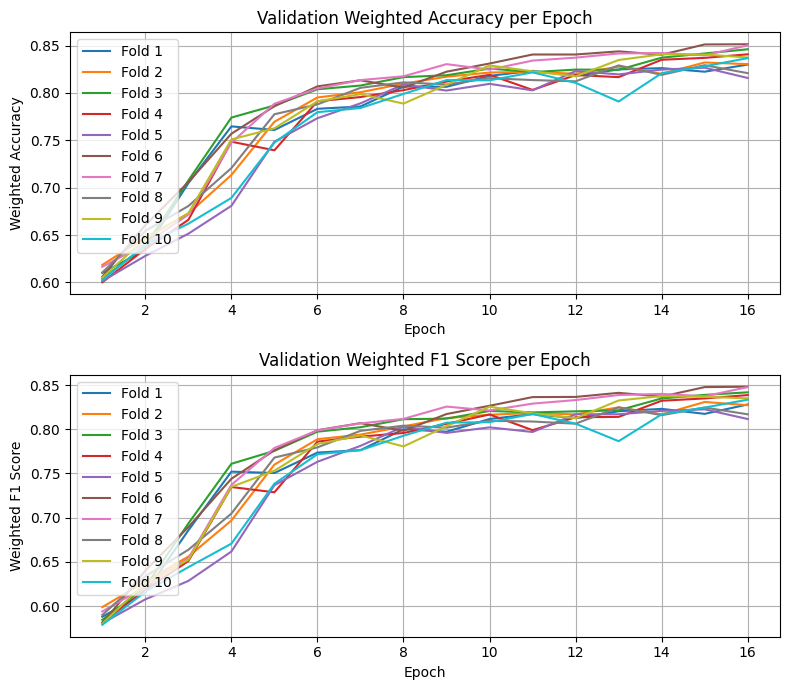

In [ ]:
results = train_model(ConvNet, dataset)